In [109]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
from scipy.integrate import cumulative_trapezoid as ct

In [110]:
df = pd.read_csv('sounding.csv')

In [111]:
df = df.drop(0) # drop row containing some nans

In [112]:
P = df['P'].values * units('hPa')
H = df['H'].values
T = df['T'].values * units('degC')
TD = df['DT'].values * units('degC')
RH = df['RH']
MIXR = df['MIXR'].values * units('g/kg')
THTA = df['THAT'].values * units('K')
THTE = df['THTE'].values * units('K')
THTV = df['THTV'].values * units('K')

In [113]:
Q = mpcalc.specific_humidity_from_dewpoint(P, TD)

In [114]:
RD = 287 * units('J kg^-1 K^-1')
RV = 461 * units('J kg^-1 K^-1')

In [115]:
T_K = T.to('K')

# TRHO = TV for the environment (there are no condensates)

In [116]:
TRHO = (1 + (((RV/RD) - 1)*Q))*T_K

In [117]:
TRHO = TRHO.to('degC')

In [118]:
P.shape, T.shape, TD.shape

((129,), (129,), (129,))

In [119]:
TD[1]

<Quantity(16.2, 'degree_Celsius')>

In [120]:
prof = mpcalc.parcel_profile(P, T[0], TD[0])

/tmp/ipykernel_2657890/1011621962.py:1: UserWarning: Duplicate pressure(s) [60.5] hPa provided. Output profile includes duplicate temperatures as a result.
  prof = mpcalc.parcel_profile(P, T[0], TD[0])


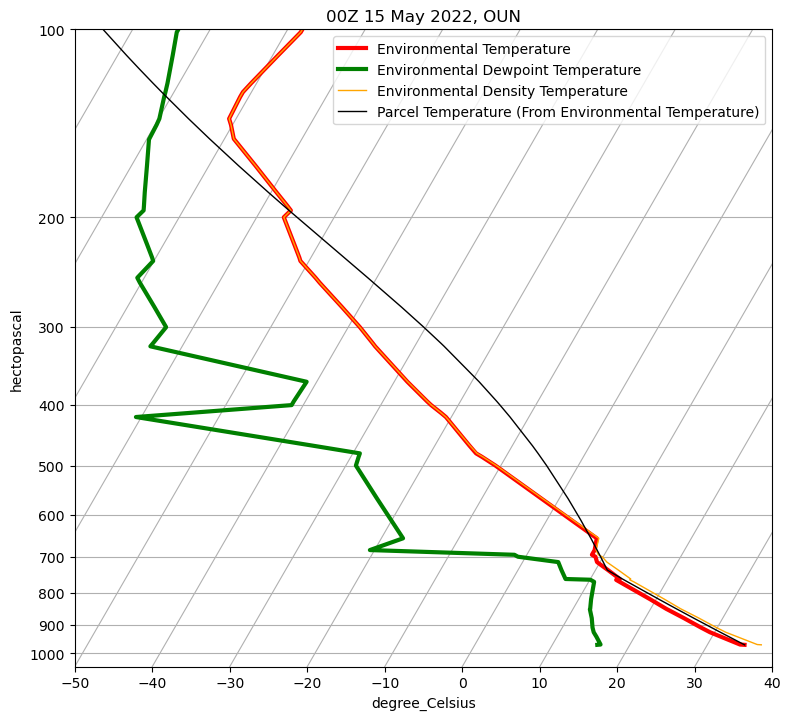

In [128]:
pTop = 100
pBot = 1050
tMin = -50
tMax = 40
logTop = np.log10(pTop)
logBot = np.log10(pBot)
interval = np.logspace(logTop,logBot) 
fig=plt.figure(figsize=(9,9))
skew = SkewT(fig, rotation=30)

skew.plot(P, T, 'r', linewidth=3, label='Environmental Temperature')
skew.plot(P, TD, 'g', linewidth=3, label='Environmental Dewpoint Temperature')
skew.plot(P, TRHO, 'orange', linewidth=1, label='Environmental Density Temperature')
skew.plot(P, prof, 'k', linewidth=1, label='Parcel Temperature (From Environmental Temperature)')

skew.ax.set_ylim(pBot, pTop)
skew.ax.set_xlim(tMin, tMax)
skew.ax.set_title('00Z 15 May 2022, OUN')

skew.ax.legend()


# Parcel path calculated with environmental temperature

# Density temperature/virtual temperature is warmer than temperature. This is because both density and virtual temperature take into account the effects of water vapor. Since here we are taking the environmental density temperature, which does not have any condensate, we are looking at the virtual temperature. Virtual temperture is the temperature a parcel of air would have to be if it was the same density as a moist parcel. Water vapor is less dense, so the temperature would have to be warmer to account for that density difference. 

In [122]:
H

array([  345,   354,   610,   762,   914,  1219,  1507,  1524,  1829,
        2134,  2377,  2438,  2444,  2466,  2743,  2989,  3153,  3212,
        3356,  3658,  3714,  4267,  4877,  5850,  6096,  6193,  6401,
        7197,  7315,  7520,  7620,  8144,  9070,  9144,  9560, 10058,
       10668, 10790, 11195, 11278, 11582, 11887, 12192, 12230, 12391,
       12497, 12802, 13411, 14010, 14021, 14326, 14463, 14935, 15044,
       15240, 15545, 15850, 16360, 16420, 16459, 16841, 16958, 17189,
       17576, 17678, 17728, 17983, 18263, 18288, 18593, 18610, 18898,
       18934, 19202, 19508, 19507, 20117, 20422, 20466, 20700, 20726,
       20841, 20987, 21336, 21641, 21946, 21970, 22250, 22353, 22555,
       23165, 23461, 23774, 23950, 24079, 24169, 24384, 24994, 25175,
       25603, 25908, 26518, 26560, 26827, 27360, 27432, 27942, 28651,
       28784, 29261, 29644, 29870, 30374, 30480, 30618, 30785, 31074,
       31210, 31394, 31848, 32075, 32310, 32808, 33264, 33528, 33660,
       33763, 34635,

In [123]:
T_kelvin = T.to('K')

In [124]:
B = (9.81*(prof - T_kelvin)/T_kelvin) # calculate buoyancy

In [125]:
integrand = ct(y=B, x=H, axis=-1, initial=0) # integrate

In [126]:
w = np.sqrt(2*integrand) # sqrt 2 cape equation

/tmp/ipykernel_2657890/401990497.py:1: RuntimeWarning: invalid value encountered in sqrt
  w = np.sqrt(2*integrand) # sqrt 2 cape equation


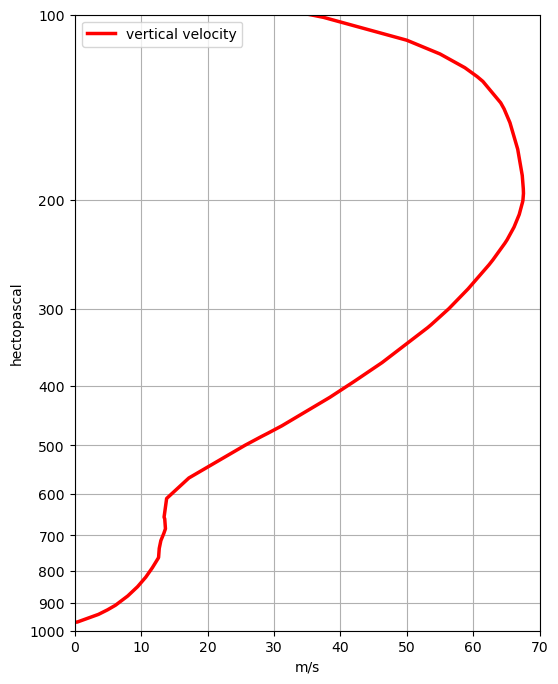

In [127]:
pressure_levels = np.array([1000, 900, 800, 700, 600, 500, 400, 300, 200, 100])
fig, ax = plt.subplots(figsize=(6, 8))
ax.plot(w, P, linewidth=2.5, color='red', label='vertical velocity')
ax.yaxis.set_inverted(True)
ax.set_ylim(1000, 100)
ax.set_xlim(0,70)
ax.set_yscale('log')
ax.set_yticks(pressure_levels)
ax.set_yticklabels([str(p) for p in pressure_levels])
ax.set_xlabel('m/s')
ax.grid()
ax.legend();

# W increases rapidly in the lower troposphere (950-800 hPa), then increases gradually from 800-600 hPa. After that, it increases rapdily again through the equillibirum level of about 200 hPa. After that point, it decreases slowly through 150 hPa, and rather rapidly above that. The maximum w occurs at the equillibrium level, since this calculation results in a compounding acceleration throughout the troposphere. That acceleration is a result of there being positive buoyancy (CAPE), which is a forcing mechanism/acceleration on the vertical velocity. Since there is continuous acceleration though the equillibrium level, the velocity increases until that point, after which is begins to deccelerate via negative buoyancy (CIN). This causes vertical velocity to begin to decrease after the equillibrium level. 